# Project 2: Hawkes Process
# Group W: Khair Mohamed - El Firdoussi Aymane - Msik Ahmed Amine

# Introduction: 
## Read the article !

Named after Halan G.Hawkes, a Hawkes process is self-exciting point process making arrival rate of events depends on past events. 
In this project, we study the time arrivals of cyber attacks, which we assume to be a Hawks process. We will use stochastic modelling techniques and log-likelihood maximization. In this paper, we will use a public dataset, "PRC.csv", that contains the dates of plenty of attacks, sorted by category and date of appearance. Our work will consist of axiizing the log-likelihood of our data, find the maximum-likelihood parameters, estimate the instensity and finally compute a sequence using this intensity. 

## Data preparation

Our work is based on the dataset from the Privacy Rights Clearinghouse (PRC). The data is comprised of publicly available information on reported breaches designed to help advocates, policymakers, journalists and researchers better understand reported data breaches in the United States.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from scipy.optimize import minimize, root_scalar
import scipy.integrate as integrate
import seaborn as sns

# All imports go here

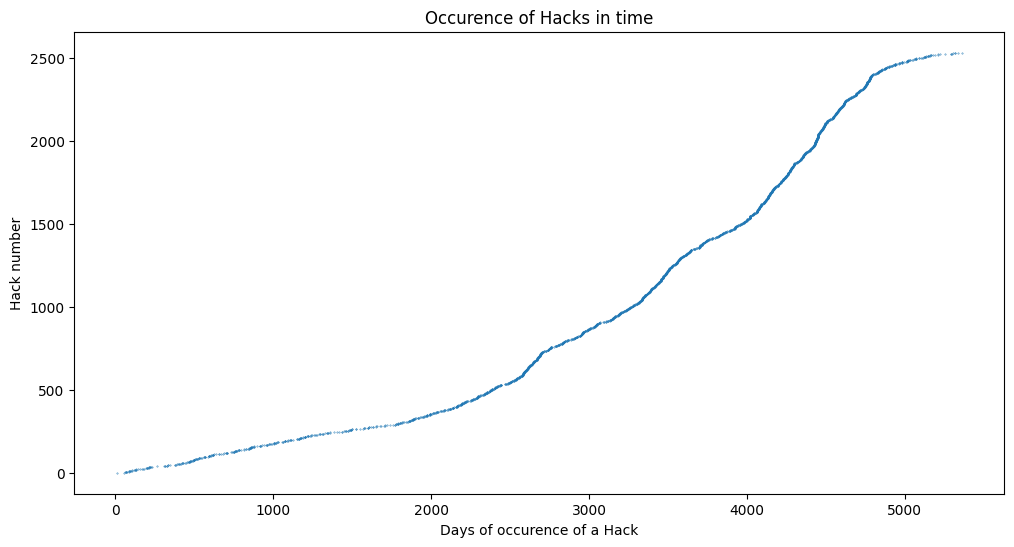

In [3]:
# Loading the data set
df = pd.read_csv("PRC.csv", sep=';')

# Taking the dates of HACKs
dff = df.loc[ df['Type of breach'] == "HACK", 'Date Made Public'] 
dff = dff.apply( lambda x:datetime.strptime(x, '%m/%d/%Y')) 

# Making the first date as 0
debut = min(dff) 
dff = dff - debut
dff = dff.apply(lambda x:x.days).sort_values()

# Sorting by date
l = np.asarray(dff)[1:]

# Plotting the 
plt.figure(figsize = (12, 6))
plt.scatter(l, 1 + np.arange(len(l)), s=0.1)
plt.xlabel("Days of occurence of a Hack")
plt.ylabel("Hack number")
plt.title("Occurence of Hacks in time")

plt.show()

## Log-likelihood

The log-likelihood is given by:
$$ \log(L(N, T)) = \sum_{T_n \leq t} \log(\alpha + \beta \sum_{j = 1}^{n - 1} e^{- \gamma (T_n - t_j)}) + (1 - \alpha) t + \frac{\beta}{\gamma} \sum_{T_n \leq t}(1 - e^{\gamma(t - T_n)})  $$

In [4]:
def log_likelihood(T, t, alpha, beta, gamma):
    logL = (1 - alpha) * t
    i = 0
    n = len(T)
    while i < n and T[i] < t:
        logL += beta * ( 1 - np.exp(-gamma * (t - T[i]))) /gamma
        s = 0
        for j in range(i):
            s+= beta* np.exp(-gamma * (T[i] - T[j]))
            
        logL += np.log(alpha + s)
        i += 1
    return logL

In [6]:
print(log_likelihood(l, 100000, 1, 0.5, 1))

2194.4649693405113


## Finding the parameters that maximize the log-likelihood

Maximizing the log-likelihood is equivalent to minimizing the negative log-likelihood, i.e:

$$ \arg \max_{\alpha, \beta, \gamma} \log(L(N, t)) =  \arg \min_{\alpha, \beta, \gamma} \: -\log(L(N, t))  $$
Under the constraints:
$$ \alpha, \beta, \gamma > 0 \: \: \: and \: \: \: \: \beta < \gamma $$
We will then use the library **scipy** to solve our minimization problem and finally retreive the the desired parameters $\alpha, \beta$ and $\gamma$.

In [7]:
# Function to minimize 
def negative_log_likelihood(param, T, t):
    return  -log_likelihood(T, t, param[0], param[1], param[2])

In [8]:
# Paramaters
x0 = (1, 1, 1)
epsilon = 1e-25
T = l
t = T[-1]

# The constraint beta < gamma
constraint = (
    {'type': 'ineq', 'fun': lambda param: param[2] - param[1]}  
)
# Optimization
res = minimize(negative_log_likelihood, x0, method='SLSQP', args = (T, t), constraints = constraint, bounds = ((epsilon, None), (epsilon, None), (epsilon, None)) , tol = 1e-6)
alpha_max = res.x[0]
beta_max = res.x[1]
gamma_max = res.x[2]
print("The optimal parameters are : \n ")
print("alpha : ", alpha_max)
print("Beta : ", beta_max)
print("Gamma : ", gamma_max)
print("the maximum is :", -negative_log_likelihood(res.x, T, t)) 

/Users/aelfirdo/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


The optimal parameters are : 
 
alpha :  0.2945974982573877
Beta :  11833.034189079914
Gamma :  12108.303097233704
the maximum is : 13636.394416888283


the optimal parameters are  [2.97076493e-01 2.43998659e+04 2.53889649e+04]
the maximum is : 14243.050210292866

## Finding $\dot{y}(N, t)$

We know that $$ \dot{y}(N, t) = \alpha + \beta \int_0^{t^-} e^{- \gamma (t - s)} \mathrm{d}N(s) = \alpha + \beta\sum_{T_n \leq t} e^{- \gamma (t - T_n)} $$

In [9]:
def y_dot(t, T, alpha, beta, gamma):
    n = 0
    N = len(T)
    s = 0

    # computing the sum
    while n < N and T[n] < t:
        s += np.exp(-gamma * (t - T[n]))
        n += 1
    return alpha + beta * s

$$ y(N, t) = \int_0^t \dot{y}(N, u) \mathrm{d}u  $$
And we want to compute the values of the sequence $(y(N, T_n(N)))_n$

In [10]:
def y(t, T, alpha, beta, gamma):
    return integrate.quad(lambda x: y_dot(x, T, alpha, beta, gamma) , 0, t)[0]

def process(T, alpha, beta, gamma):
    Y = []
    for i in range(len(T)):
        Y.append(y(T[i], T, alpha, beta, gamma))
    return np.array(Y)

def inter_arrivals(Y):
    return Y[1 :] - Y[ : -1]

In [11]:
Y = process(T, alpha_max, beta_max, gamma_max)
inter = inter_arrivals(Y)

In [17]:
print(Y)
print(inter)

[   2.37286242   16.90664471   17.79646812 ... 1578.25011444 1584.18227048
 1591.00424993]
[14.5337823   0.88982341  1.48303901 ...  0.2966078   5.93215604
  6.82197945]
-7.2090953294861135


## Verifying that the process $(y(N, T_n(N)))$ is Poisson of intensity 1

## First method: Graphically:
To verify graphically that the random variables comprising the process of inter-arrivals $(\xi_i)_{i \in {1, ..., N}}$ are of exponential law $\mathcal{E}(1)$, we can plot the histogram of their values and see if it has the shape of the exponential density $$ f(x) = e^{- x} \mathbb{1}_{x \geq 0} $$
We can also plot the kernel density estimation function, whihc we will precise its expression in the next method. 

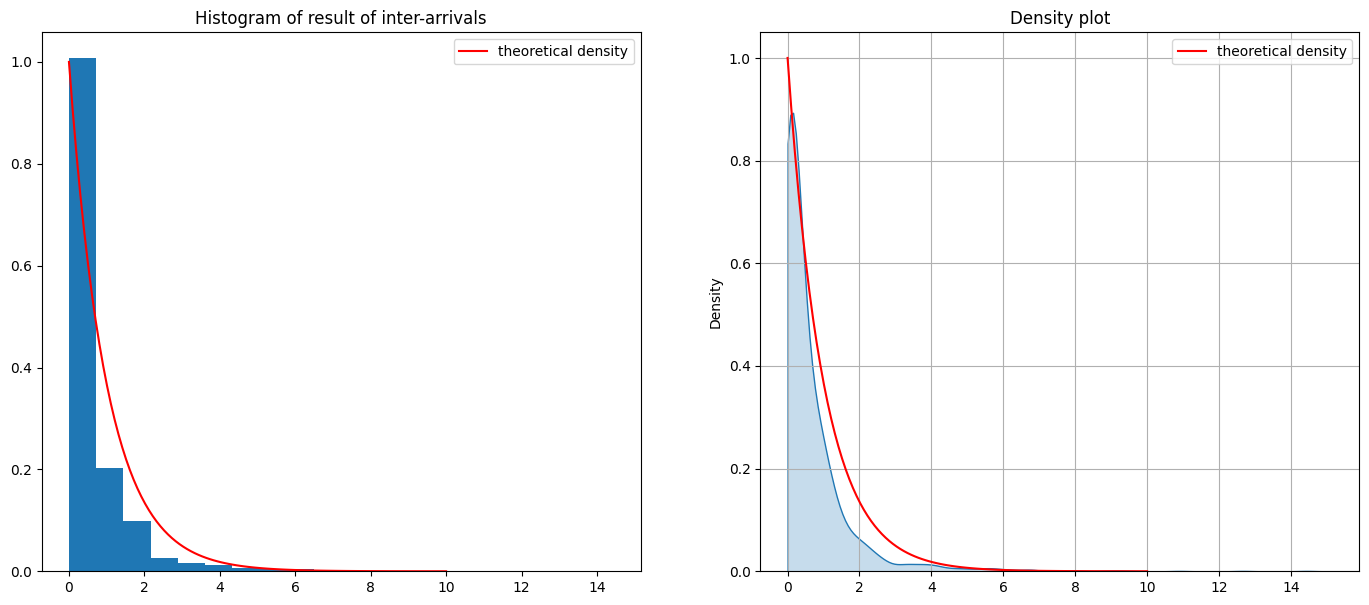

In [19]:
f = lambda x: np.exp(-x)
t = np.linspace(0, 10, 100)

# Plotting the comparisoon between densities
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 7))

# Plot the histogram of data
axs[0].hist(inter, density = True, bins = 20)
axs[0].set_title('Histogram of result of inter-arrivals')
axs[0].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[0].legend()

# Plot the True density
sns.kdeplot(data = inter, fill=True, ax=axs[1], bw_method='silverman', clip=(0, None))
axs[1].plot(t, f(t), label = 'theoretical density', c = 'r')
axs[1].set_title('Density plot')
axs[1].grid()
axs[1].legend()

# Show the plot
plt.show()

## Second method: Compute the Kullback-Leibler divergence

We know that the Kullback-Leibler divergence is a non-negative metric that measures how two probability distributions $\mu$ and $\pi$ are far from each other. Its expression is given by:

$$ KL(\mu | \pi) = \int \log(\frac{\mu(x)}{\pi(x)}) \mu(x) dx $$

The KL divergence has this nice property:
$$ KL(\mu | \pi) \geq 0 $$
And $$ KL(\mu | \pi) = 0 \Longleftrightarrow \mu = \pi $$
Therefore, to show that the inter-arrivals $(\xi_i)_{i \in {1, .., N}}$ follow an exponential law $\mathcal{E}(1)$, we should compute the KL divergence between the density of these random variables which we denote $\mu$, and the target density $\pi$ which is the exponential density of parameter 1, i.e :
$$ \pi(x) = e^{-x} \mathbb{1}_{x \geq 0} $$
And to estimate $\mu$, we can use the Kernel estimation of the density of the random variables $(\xi_i)_{i \in {1, .., N}}$, which means that:
$$ \mu(x) = \frac{1}{N h} \sum_{i = 1}^{N} K \left(\frac{\xi_i - x}{h} \right)  $$
where $h > 0$ is called the window of the kernel. We can take the Gaussian kernel for example, which is given by:
$$ K(x - y) = \exp \{- \sigma (x - y)^2 \}  $$
We can take $\sigma = 1$ (because we can control this variable using $h$).

Using these expressions, we can now compute the KL divergence: 
$$ KL(\mu | \pi) = \int (log(\mu(x)) + x) \mu(x) \mathrm{d}x $$
Let us begin by defining the functions that we will need to compute the KL.

In [72]:
# The Kernel density estimation
def kde_gauss(X, h, t):
    """
    X : the list of random variables
    h : the window size
    t : the instant in which we want to compute the estimation
    """
    N = len(X)
    s = 0
    for i in range(N):
        s += np.exp(-(X[i] - t)**2 / h**2)
    return s /(N * h)

def KL(X, h):
    g = lambda x: (np.log(kde_gauss(X, h, x)) + x) * kde_gauss(X, h, x)
    return integrate.quad(g, 0, 20)[0]

def fct(X, h, t):
    return (np.log(kde_gauss(X, h, t)) + t) * kde_gauss(X, h, t)
    

### Let us first plot these quantitites

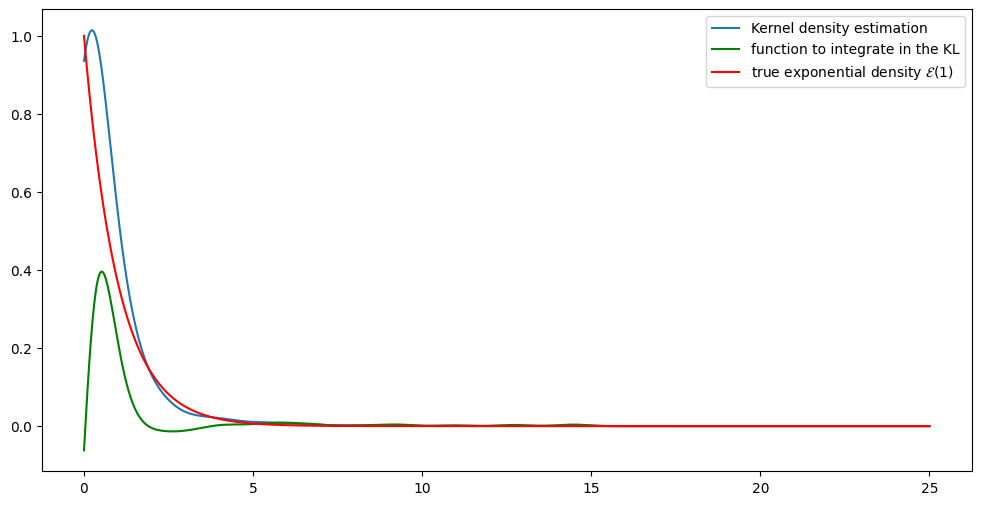

In [80]:
# Plotting the kernel density estimation
h = 0.7
plt.figure(figsize=(12, 6))
t = np.linspace(0, 25, 1000)
plt.plot(t, kde_gauss(inter, h, t), label = 'Kernel density estimation')

# Plotting the quantity inside the integral of the KL
plt.plot(t, fct(inter, h, t), c = 'g', label = 'function to integrate in the KL')

# Plotting the true exponential density
f = lambda x: np.exp(-x)
plt.plot(t, f(t), c = 'r', label = 'true exponential density $\mathcal{E}(1)$')
plt.legend()
plt.show()

### Prior observation:
We observe that the quantity $ x \mapsto (\log(\mu(x)) + x) \mu(x)$ becomes null when $x$ becomes larger than $20$. Hence, instead of integrating it from $0$ to $+ \infty$, we can integrate it only from $0$ to $20$. This will decrease the complexity of our method and give a very goof approximation of the theoretical KL.

In [81]:
# Paramters
h = 0.7

# The value of the KL divergence
kl = KL(inter, h)
print(kl)


0.36885779265768953


### $$ \mathcal{Observation} $$
The value of the KL divergence is small, then $\mu = \pi$, then we can conclude that the random variables $(\xi_i)_{i \in \{1, ..., N \}}$, are of exponential law of parameter 1 ($\mathcal{E}(1)$).

### Third method: Test of Kolmogorov

In [87]:
def empirical_cdf(X, t):
    N = len(X)
    mask = X < t
    return len(X[mask]) / N

def exp_cdf(t):
    return 1 - np.exp(-t)

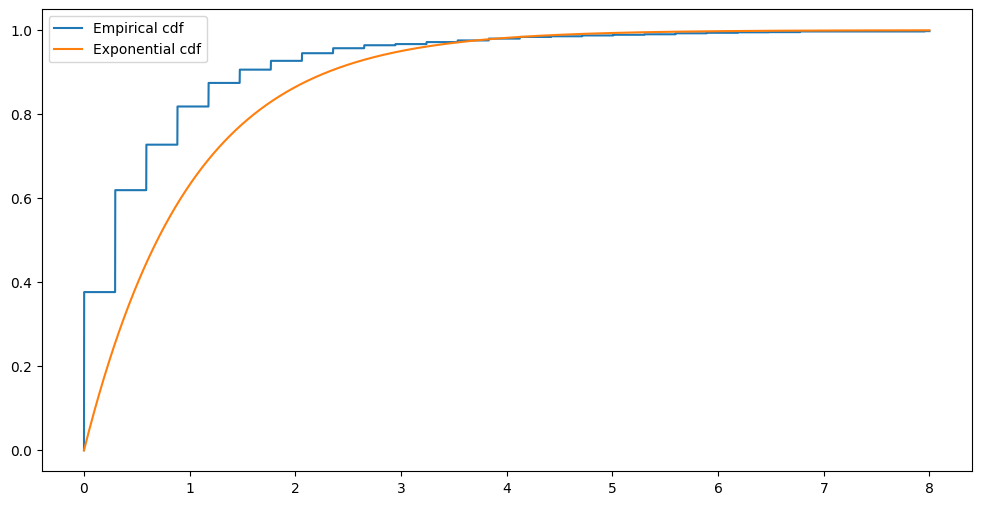

In [98]:
# Plotting the empirical density and the true one
t = np.linspace(0, 8, 10000)
plt.figure(figsize=(12, 6))

# Empirical cdf
values = []
for k in t:
    values.append(empirical_cdf(inter, k))
plt.plot(t, values, label = 'Empirical cdf')

# True cdf
plt.plot(t, exp_cdf(t), label = 'Exponential cdf')
plt.legend()
plt.show()